In [1]:
#Imports
from tensorflow.keras.models import Sequential, model_from_json, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
import os
import pandas as pd
import numpy as np
import pickle as pk
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
list_nPCs = [10, 15, 20, 25, 30, 35, 40]
takeprofit = 0.12
stoploss = 0.05

In [3]:
#Load previously built datasets : we just need train sets and validation sets here
trainset_final = pd.read_csv('./Data/Trainset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
trainset = pd.read_csv('./Data/Trainset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

validation_set_final = pd.read_csv('./Data/Validationset_final_SL{}_TP{}.csv'.format(stoploss, takeprofit))
validation_set = pd.read_csv('./Data/Validationset_SL{}_TP{}.csv'.format(stoploss, takeprofit))

In [4]:
# Hotfix function
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))
    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [5]:
#Build and train several models different amounts of PCs
for nPCs in list_nPCs:
    print(nPCs)
    X = trainset_final.iloc[:, :nPCs]
    y = trainset["result"]

    # Build model and train it
    classifier = Sequential()
    dropout_fraction = 0.2
    #First Hidden Layer
    classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=nPCs))
    classifier.add(Dropout(dropout_fraction))
    #Second, third and fourth  hidden Layers
    classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))
    classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))
    classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
    classifier.add(Dropout(dropout_fraction))

    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    #Fitting the data to the training dataset
    classifier.fit(X,y, batch_size=15, epochs=100, verbose =1)

    pk.dump(classifier, open("./Models/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit),"wb"))

.0000
35
Epoch 1/100
15/15 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4930
Epoch 2/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6932 - accuracy: 0.4707
Epoch 3/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6929 - accuracy: 0.5203
Epoch 4/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.5726
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6909 - accuracy: 0.6431
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.8654
Epoch 7/100
15/15 [==============================] - 0s 1ms/step - loss: 0.6435 - accuracy: 0.9012
Epoch 8/100
15/15 [==============================] - 0s 1ms/step - loss: 0.5428 - accuracy: 0.9373
Epoch 9/100
15/15 [==============================] - 0s 1ms/step - loss: 0.3469 - accuracy: 0.9537
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9601


In [6]:
X_test = validation_set_final
y_test = validation_set['result']

In [9]:
accuracies, nPCs_list = [], []
for nPCs in list_nPCs:
    print(nPCs)
    with open("./Models/DL_model_{}PC_stoploss{}_takeprofit{}.pkl".format(nPCs, stoploss, takeprofit), 'rb') as f:
        clf = pk.load(f)
    # Compute predictions on testset
    preds = (clf.predict(validation_set_final.iloc[:, :nPCs]) > 0.5)*1

    # Assess accuracy on Bullish predictions only (because we assume only performing Bullish trades) 
    validation_set1 = validation_set[preds == 1].copy()
    accuracies.append(np.mean(preds == list(validation_set['result'])))
    nPCs_list.append(nPCs)

10
15
20
25
30
35
40


In [10]:
recap = pd.DataFrame({'nPCs' : list(nPCs_list), 'Accuracy' : (list(accuracies))})
recap.to_csv('./Results/Comparative_All_models_stoploss{}_takeprofit{}.csv'.format(stoploss, takeprofit), index = False)
print(recap)

   nPCs  Accuracy
0    10  0.611111
1    15  0.628889
2    20  0.473333
3    25  0.526667
4    30  0.495556
5    35  0.460000
6    40  0.522222


In [35]:
print(clf.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                1312      
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_26 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)               

In [53]:
import tensorflow as tf

X = trainset_final.iloc[:, :15]
y = trainset["result"]
X_val = validation_set_final.iloc[:, :15]
y_val = validation_set['result']
# Build model and train it
classifier = Sequential()
dropout_fraction = 0.2
#First Hidden Layer
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal', input_dim=15))
classifier.add(Dropout(dropout_fraction))
#Second, third and fourth  hidden Layers
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dropout(dropout_fraction))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[
    "accuracy",
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="auc"),
    ])
#Fitting the data to the training dataset
model = classifier.fit(X,y, batch_size=15, epochs=100, validation_data=(X_val, y_val), verbose =1)

000 - val_recall: 0.0909 - val_auc: 0.5502
Epoch 49/100
15/15 [==============================] - 0s 5ms/step - loss: 0.1049 - accuracy: 0.9655 - tp: 61.7500 - tn: 59.0625 - fp: 4.2500 - fn: 1.1250 - precision: 0.9521 - recall: 0.9816 - auc: 0.9893 - val_loss: 5.8587 - val_accuracy: 0.6167 - val_tp: 1.0000 - val_tn: 36.0000 - val_fp: 2.0000 - val_fn: 21.0000 - val_precision: 0.3333 - val_recall: 0.0455 - val_auc: 0.5502
Epoch 50/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0909 - accuracy: 0.9831 - tp: 58.9375 - tn: 64.6875 - fp: 2.5625 - fn: 0.0000e+00 - precision: 0.9649 - recall: 1.0000 - auc: 0.9917 - val_loss: 6.5027 - val_accuracy: 0.6167 - val_tp: 1.0000 - val_tn: 36.0000 - val_fp: 2.0000 - val_fn: 21.0000 - val_precision: 0.3333 - val_recall: 0.0455 - val_auc: 0.5610
Epoch 51/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0948 - accuracy: 0.9817 - tp: 59.9375 - tn: 63.4375 - fp: 1.8125 - fn: 1.0000 - precision: 0.9761 - recall: 0.9864 - 

In [48]:
epochs = 100

    Epoch     Train        Val
0       1  0.693157   0.692682
1       2  0.693019   0.691867
2       3  0.692670   0.690152
3       4  0.691570   0.685970
4       5  0.687496   0.672385
5       6  0.667706   0.635617
6       7  0.619689   0.609304
7       8  0.514460   0.780968
8       9  0.386491   1.261615
9      10  0.316367   1.591842
10     11  0.261341   1.760595
11     12  0.280632   2.061513
12     13  0.280006   2.178668
13     14  0.281921   2.091608
14     15  0.260253   2.041694
15     16  0.270928   2.235238
16     17  0.233909   2.386050
17     18  0.222875   2.350000
18     19  0.192101   2.622732
19     20  0.180597   2.823357
20     21  0.230382   2.645097
21     22  0.186034   2.349117
22     23  0.179904   2.558028
23     24  0.187855   2.754584
24     25  0.203770   2.993440
25     26  0.168039   3.051510
26     27  0.163914   3.289843
27     28  0.147500   3.567530
28     29  0.205084   3.662721
29     30  0.167794   3.789316
..    ...       ...        ...
70     7

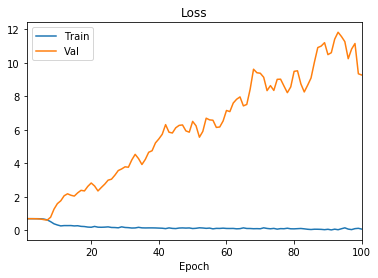

In [54]:
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["loss"],
        "Val": model.history["val_loss"],
    }
)
print(loss_df)
loss_df.set_index("Epoch", inplace=True)
loss_df.plot(title="Loss")

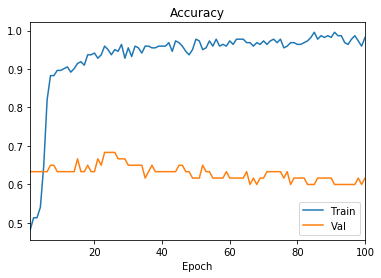

In [55]:
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["accuracy"],
        "Val": model.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)
accuracy_df.plot(title="Accuracy")

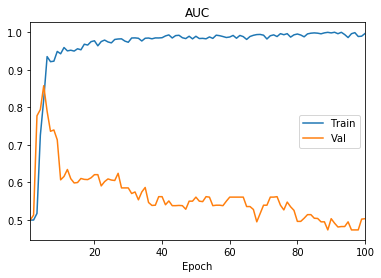

In [56]:
# Plotting AUC
auc_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": model.history["auc"],
        "Val": model.history["val_auc"],
    }
)
auc_df.set_index("Epoch", inplace=True)
auc_df.plot(title="AUC")

In [24]:
results = validation_set.copy()

In [27]:
results['preds'] = preds

In [29]:
results = results[['result','preds']]

In [30]:
results

,result,preds
0,1,0
1,0,0
2,1,1
3,1,0
4,0,0
5,0,0
6,1,0
7,1,0
8,0,0
9,0,0
